# IFU Data Modeling NGC 4151 Notebook #1 -  Isolating Line Emission


**Use case:** continuum and  emission-line modeling of AGN; 1.47-1.87um.<br>
**Data:** [NIFS](https://www.gemini.edu/instrumentation/current-instruments/nifs) on Gemini; NGC 4151.<br>
**Tools:**  specutils, jdaviz/cubeviz, astropy, matplotlib, bottleneck.<br>
**Cross-intrument:** NIRSpec; potentially MIRI <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

## Introduction

This notebook uses an example 3-D IFU Datacube of the Active Galactic Nucleii NGC 4151 [Storchi-Bergmann et al. 2009,  MNRAS, V 394, pp. 1148-1166](https://ui.adsabs.harvard.edu/abs/2009MNRAS.394.1148S/abstract).  This is a ground-based AO-fed H-band dataset (1.47-1.87um) from the Near-Infrared Integral Field Spectrograph (NIFS) instrument at the Gemini Observatory.  NIFS is a very similar image slicing IFU to JWST NIRSpec.

This notebook performs some simple spectral investigations.  The notebook utilizes [jdaviz/cubviz](https://github.com/spacetelescope/jdaviz) to inspect the dataset and extract 1-D spectra.  The continuum is fit in a region near to the 1.644um [Fe II] emission from the AGN outflow and subtracted.  The centrally compact atomic Hydrogen Brackett 12 feature, which is nearby in wavelength and contaminates the [Fe II] outflow emission, is also fit and removed.  The data sub-cubes of the continuum model and the isolated and continuum subtracted [Fe II] emission are then saved.  These saved data sets will ultimately serve as starting points for the future notebooks in this set.

**Note:** This notebook is designed to analyze the 1.6440 [Fe II] emission but the wavelengths can be altered to fit and remove continuum around any emission line of interest.

## Imports
 - time for timing
 - numpy for array processing and math
 - matplotlib.pyplot for plotting images and spectra
 - astropy.io for reading and writing FITS cubes and images
 - astropy.modeling for modeling spectral curves
 - astropy.utils.data for accessing the data
 - specutils.fitting for spectral data fitting
 - specutils Spectrum1D for modeling emission lines
 - jdaviz.app to use cubeviz in the notebook



In [1]:

# load important packages
import time
from copy import copy

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy import units as u
from astropy.modeling import models
from astropy.utils.data import download_file
from specutils.fitting import fit_lines
from specutils import Spectrum1D

from jdaviz.app import Application


In [2]:

# load and configure matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})


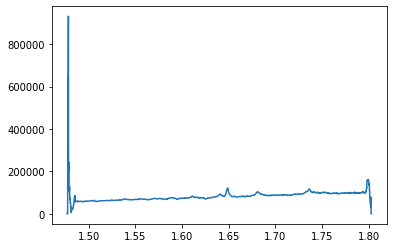

In [3]:

#This cell access the datacube file, defines the wavelength grid from header information and then plots a simple
# 1-D collapsed spectrum of the IFU data.

# Read in a 3-D IFU datacube of interest, and header.
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits', cache=True)
cube = fits.getdata(cube_file)
header_cube = fits.getheader(cube_file)

#grab data information and wavelength definitions.
nz, ny, nx = cube.shape
crdelt3 = header_cube['CDELT3']
crval3 = header_cube['CRVAL3']

#define the wavelength grid (microns) from the header (Angstroms)
# and the AGN redshift and the emission line of interest.
wave =((crdelt3 * (np.arange(0,nz,1))) + crval3)/10000.0
redshift = 0.00332
emission_line = 1.64400*(1 + redshift)
emission_line_index = (np.abs(wave-emission_line)).argmin()

# make a simple summed 1d spectrum of the full cube
flux1 = np.sum(cube, axis=(1,2))

# plot the full 1-D spectrum.
plt.figure(0)
plt.plot(wave, flux1)
plt.show()


We see that the spectral edges of the summed 1D are 'ratty'.  The 1D spectral array goes beyond the nominal useable data range of the instrument.  We'll ignore the poor spectral regions and focus on the AGN flux.

The [Fe II] feature that we are interested in is the bright, strong emission just shortward of 1.65um.  The contaminating H I Br 12 emission is just blueward of the [Fe II].

We can use this plot window to read wavelength values of interest to define our analysis spectral ranges (see wavelength/flux grid data to the lower right of the plot window).

Special Note - in this particular dataset, a portion of the spectrum on the red side of the [FeII] emission
provides a clean measure of the continuum.  The blue-ward side of the [Fe II]
and HI Brackett 12 emission has other emission and absorption features that make clear continuum ID very 
difficult.  As a result, it is more accurate to do a simple linear fit to the red side of the spectrum rather than
a more expanded spectral region that encompasses the emission..

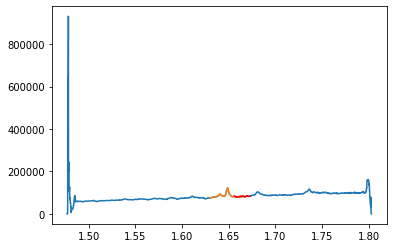

In [4]:

#This cell defines the wavelength regions of interest: around the emission line, and the location
#where you want to fit and remove the continuum very accurately.  Make a plot that shows the regions.

# Here we select a region that includes the emission line
# wavelength plus a small range of continuum around it.  
# Determine these limits by investigating the flux in the above plot.  Read
# the wavelength values off of the plot information at the lower right.

wave_emission_limit1 = 1.630
wave_emission_limit2 = 1.665

# Here we define a spectral range where we will use the
# flux to generate a continuum model.  The flux shape in this
# AGN is quite linear around the redward emission, so we will use only a 
# short segment of the spectrum on the red side of the emission 
# feature.
# We again determine these values by investigating the wavelengths in the
# above plot window.

continuum_limit1 = 1.656
continuum_limit2 = 1.673
  
#Define the wavelength region around the emission - indices
wavemin = (np.abs(wave-wave_emission_limit1)).argmin()
wavemax = (np.abs(wave-wave_emission_limit2)).argmin()

# Define the wavelength region used to fit the continuum flux level  - indices.
continuummin = (np.abs(wave-continuum_limit1)).argmin()
continuummax = (np.abs(wave-continuum_limit2)).argmin()

#show the region used for the emission line and continuum fit.  Alter the wavelengths 
# above if this doesn't look good.  
plt.figure(1)
plt.plot(wave, flux1)
plt.plot(wave[wavemin:wavemax], flux1[wavemin:wavemax])
plt.plot(wave[continuummin:continuummax], flux1[continuummin:continuummax],color='r')
plt.show()


 For this particular dataset, this continuum region looks very good.
 if you have a more structured continuum you can define additional
 regions and append them into a larger set of wave / flux arrays to 
 derive a more accurate fit in the below poly-fit analysis.

In [5]:

# Use cubeviz to look at the data in the cube.  Here, we configure and bring up the app.
app = Application(configuration='cubeviz')
app


/Users/gough/bob/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n …

In [6]:

# Here, we load the data into the cubeviz app.
app.load_data(fn)
 


Set the left cubeviz panel to view our cube by linking the dataset to the visualization.  This is done in the cube visualization panel that is to the upper left; it is an expandible menu that shows up as lines at the left display view.  When you click the gear icon in this expanded menu, the dataset should show up as a weird name next to a blank checkbox.  Check the box.

In the same way, select the datacube in the spectral viewer at the bottom of the cubeviz pane.
Use the expandible menu gear icon and select the loaded datacube.  This is the summed 1-D spectrum from the full spatial field of the data cube. 

In the datacube viewing panel, you can also select the 'layer' tab in the gear (data) icon and change 
display scaling.  Decreasing the maximum display value by 10x brings out the low level extended emission
in this dataset.  In this cube, data from slice ~1060 to ~1090 shows the extended [Fe II] emission.  

In [7]:
# show the 1-D spectrum by grabbing the cubeviz spectral viewer app within the notebook.
# If the 1-D spectrum hasn't been selected in the cubeviz window, automatically collapse
# and plot the loaded data cube.

spectrum_viewer = app.get_viewer('spectrum-viewer')
if not spectrum_viewer.data():
    app.add_data_to_viewer('spectrum-viewer',app.data_collection[0].label)
#    spectrum_viewer.add_data(app.data_collection[0].label)
                             
spectrum_viewer.show()

LayoutWidget(controls={'toolbar_selection_tools': BasicJupyterToolbar(tools_data={'bqplot:home': {'tooltip': '…

Use the flux viewer in cubeviz to extract a spectrum located at the central AGN position.
It should show in the above spectral viewer, too.

To do this, use the expandable menu at the left of the flux viewer window and select the 'define circular region of interest' icon.  Make a circular region at the central position of the bright AGN flux, which is at approximately the cube center position.

(If the notebook is being run non-interactively, this cell will automatically make a dataset that mimics the AGN specrum).

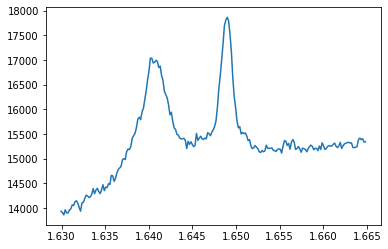

In [8]:
# Grab the layer spectrum that corresponds to the central AGN position as an array in the notebook, then plot it.
# If there is no subset in cubeviz, make one to plot.

spec_agn = app.get_data_from_viewer('spectrum-viewer', 'Subset 1')
spec_agn

if not spec_agn:
    flux_agn = np.sum(cube[:,(ny//2)-3:(ny//2)+3,(nx//2)-3:(nx//2)+3], axis=(1,2))
    spec_agn = Spectrum1D(flux=flux_agn*u.Unit('count'), spectral_axis=wave*u.micron) 
    
# plot the 1-D spectrum of this smaller sub-region.
plt.figure(2)
plt.plot(wave[wavemin:wavemax], spec_agn.flux[wavemin:wavemax])
plt.show()

Now, use the flux viewer and again use the 'define circular region of interest' icon to make spectra at two positions associated with the outflow emission in [Fe II].

The redshifted outflow is at approximate x position = 12, y position = 36.  This will be 'Subset 2' and will show up in green in the display.

The blueshifted outflow is at approximately x position = 50, y position = 28 in pixel index units.  This will be 'Subset 3' and will show up in blue in the display.

(If the notebook is being run non-interactively, automatically make two datasets that mimic the AGN outflow red/blueshifted spectra).

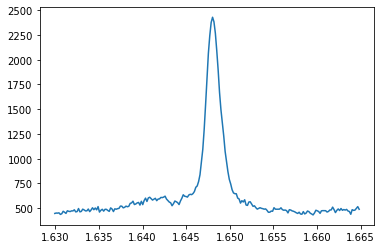

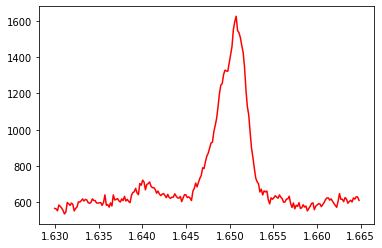

In [9]:

#grab the redshifted and blueshifted outflow spectra from the spectral viewer window.

spec_feii_red = app.get_data_from_viewer('spectrum-viewer', 'Subset 2')
spec_feii_red

if not spec_feii_red:
    flux_feii_red = np.sum(cube[:,(36)-3:(36)+3,(12)-3:(12)+3], axis=(1,2))
    spec_feii_red = Spectrum1D(flux=flux_feii_red*u.Unit('count'), spectral_axis=wave*u.micron) 

spec_feii_blue = app.get_data_from_viewer('spectrum-viewer', 'Subset 3')
spec_feii_blue

if not spec_feii_blue:
    flux_feii_blue = np.sum(cube[:,(28)-3:(28)+3,(50)-3:(50)+3], axis=(1,2))
    spec_feii_blue = Spectrum1D(flux=flux_feii_blue*u.Unit('count'), spectral_axis=wave*u.micron) 

#plot a zoomed view of the spectra grabbed from cubeviz

# plot the 1-D redshifted outflow spectrum.
plt.figure(3)
plt.plot(wave[wavemin:wavemax], spec_feii_blue.flux[wavemin:wavemax])
plt.show()

# plot the 1-D spectrum blueshifted outflow spectrum.
plt.figure(3)
plt.plot(wave[wavemin:wavemax], spec_feii_red.flux[wavemin:wavemax], color='r')
plt.show()


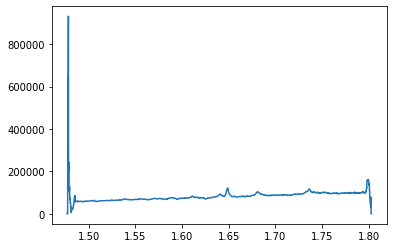

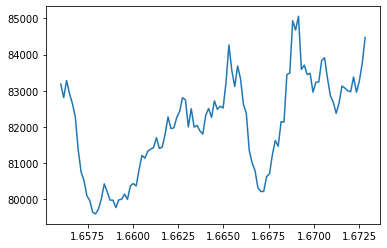

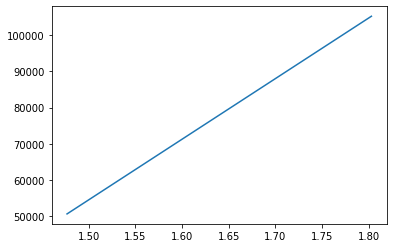

In [10]:

#demonstration of a linear fit to the continuum flux level
# this method uses simple functions in numpy to fit the continuum. 

cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)
fitval = np.poly1d(cont_fit)
continuum = fitval(wave)

plt.figure(4)
plt.plot(wave, flux1)
plt.show()

plt.figure(4)
plt.plot(wave[continuummin:continuummax], flux1[continuummin:continuummax])
plt.show()

plt.figure(4)
plt.plot(wave, continuum)
plt.show()


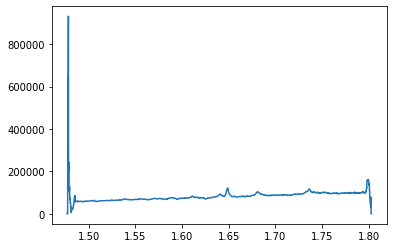

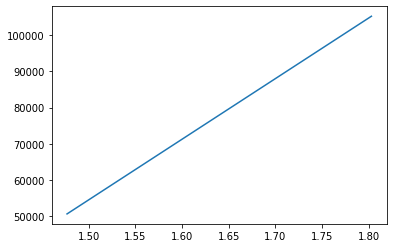

In [11]:
# That looks pretty good.

# This cell continues a demonstration of a linear fit to the continuum flux level.
# This method uses the specutils and modeling packages available
# in astropy.  It does the same thing as the prior cell, but in an astropy 
# spectral format.

# Here we use the polynomial routine to do a linear fit - this is so it's easy
# to update the fit order, if necessary.

full_spectrum=Spectrum1D(
    flux=flux1* u.Unit('count'), spectral_axis=wave* u.micron)

# Make Spectrum1D specutils version of data for the continuum segment.
spectrum = Spectrum1D(
    flux=flux1[continuummin:continuummax]*u.Unit('count'),
    spectral_axis=wave[continuummin:continuummax]*u.micron)

# Make an empty model with no initial guess of the coefficients
# If guessing make sure to only pass values (no units)
m = models.Polynomial1D(degree=1) # You can place a guess by setting c0 and c1
# Fit model and save fitted model containing the fitted params
fitted_model = fit_lines(spectrum, m)
# Just to showcase how to access the fitted params
cont_fit = [fitted_model.c1.value, fitted_model.c0.value]

# notice I dont have to use cont_fit to get my continuum
# I just call the model with my spectral values
continuum = fitted_model(full_spectrum.spectral_axis)

#plot the results - identical to above numpy code - looks good.
plt.figure(5)
plt.plot(wave, flux1)
plt.show()

plt.figure(5)
plt.plot(wave, continuum)
plt.show()


In [12]:

# This cell makes a data sub-cube around the emission feature that has the continuum flux 
# level subtracted off. then make another datacube that is only the continuum flux, to serve
# as a PSF model to correct out the bright, central HI features.

# Here I'm using the numpy functions for continuum fitting and subtraction.

# This is done in nested for loops, looping over the spatial axes in the cube.

start_time = time.time()

cont_sub_cube=np.zeros([nz,ny,nx])
cont_psf_cube=np.zeros([nz,ny,nx])

for i in range(1, nx-2):
    for j in range(1, ny-2):
        flux1 = cube[:,j,i]      
        cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)
        fitval = np.poly1d(cont_fit)
        continuum = fitval(wave)        
        cont_sub_cube[:,j,i]= flux1 - continuum
        cont_psf_cube[:,j,i]= continuum 

del header_cube['MODE']

fits.writeto('NGC4151_Hband_ContinuumSubtract.fits', cont_sub_cube, header_cube, overwrite=True)
fits.writeto('NGC4151_Hband_ContinuumPSF.fits', cont_psf_cube, header_cube, overwrite=True)
print('Continuum subtracted cube saved. PSF continuum cube saved.')

print('Time count')
print("--- %s seconds ---" % (time.time() - start_time))


Continuum subtracted cube saved. PSF continuum cube saved.
Time count
--- 0.8695571422576904 seconds ---


In [13]:

# This cell does the same thing as the prior cell, but uses specutils models polyfit instead of numpy 
# to do the continuum fitting.  This uses the poly fit options instead of line fitting so that you can 
# change the polynomial order for the continuum fitting, if necessary.

# This is done in nested for loops, looping over the RA, Dec axes in the cube.

# This does the same thing but is slow compared to the prior cell...

start_time = time.time()

cont_sub_cube_specutils=np.zeros([nz,ny,nx])
cont_psf_cube_specutils=np.zeros([nz,ny,nx])

for i in range(1, nx-2):
    for j in range(1, ny-2):
        flux1 = Spectrum1D(flux = cube[:,j,i]*u.Unit('count'), spectral_axis=wave*u.micron)
        m = models.Polynomial1D(degree=1)
        fitted_model = fit_lines(flux1[continuummin:continuummax], m)
        cont_fit = [fitted_model.c1.value, fitted_model.c0.value]
        continuum = fitted_model(flux1.spectral_axis)
        cont_sub_cube_specutils[:,j,i]= flux1.flux - continuum
        cont_psf_cube_specutils[:,j,i]= continuum

print('Done')

print('Time count')
print("--- %s seconds ---" % (time.time() - start_time))


Done
Time count
--- 21.77444314956665 seconds ---


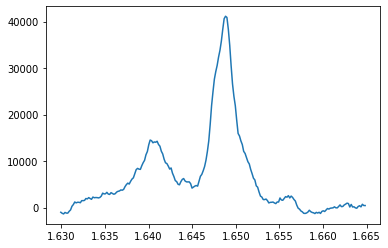

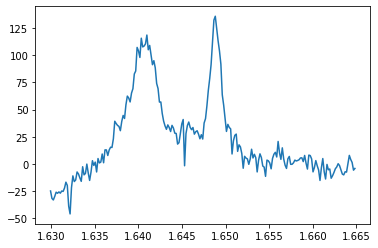

In [14]:

# Now, let's take a look at the emission line in the continuum by plotting some of the results
# of the subtracted cube.
flux1=np.sum(cont_sub_cube, axis=(1,2))

# plot the 1-D spectrum of the full continuum subtracted cube
plt.figure(6)
plt.plot(wave[wavemin:wavemax], flux1[wavemin:wavemax])
plt.show()

# plot the 1-D spectrum of a single spaxel.
plt.figure(7)
plt.plot(wave[wavemin:wavemax], cont_sub_cube[wavemin:wavemax,30,30])
plt.show()


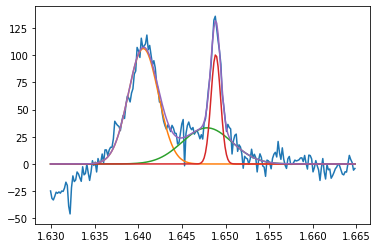

In [15]:

# This cell builds the spectrum at the central location into the format
# needed for use with specutils.  It then investigates an initial fit to the
# Br 12 emission feature, which is a pesky contaminant nearby in wavelength
# to our target [Fe II] emission.  The Br 12 is centrally compact and arises from
# only from the nucleus of the AGN, not from the outflow.  Make a plot of the fit
# results.

#zoom in wavelength into the region of interest, create subcube and subwave arrays.
flux = (cont_sub_cube[wavemin:wavemax,30,30])
minwave = wave[wavemin:wavemax]

# put the flux spectrum into the spec utils expected format.
spectrum = Spectrum1D(flux=(flux)*u.Unit('count'), spectral_axis=minwave*u.micron)

#define the fit the line for the Brackett emission (position was found by hand @ pix 1023):
# the central emission is best fit by two gaussian components: one @ br12, one @ [Fe II].
# Here we fit a third component too: the [Fe II] outflow emission.
l1 = models.Gaussian1D(amplitude = (flux[1023-wavemin])*u.Unit('count'), mean = minwave[1023-wavemin]*u.micron, stddev = 0.0009*u.micron)
l2 = models.Gaussian1D(amplitude = (flux[emission_line_index-wavemin])*u.Unit('count'), mean = minwave[emission_line_index-wavemin]*u.micron, stddev = 0.005*u.micron)
#define and fit the line for the outflow [Fe II] emission:
l3 = models.Gaussian1D(amplitude = (flux[emission_line_index-wavemin])*u.Unit('count'), mean = minwave[emission_line_index-wavemin]*u.micron, stddev = 0.0008*u.micron)

#run the lfit - this tweaks the above parameters to optimize the fits of the three components.
lfit = fit_lines(spectrum, l1 + l2 + l3)
#make the yfit
y_fit = lfit(minwave*u.micron)

# Build the fits from the fit_lines function into specutils format for plotting.
lineflux = (lfit[0](minwave*u.micron))
linemodel = Spectrum1D(spectral_axis=minwave*u.micron, flux=lineflux*u.Unit('count'))

component1 = lfit[0](minwave*u.micron)
component2 = lfit[1](minwave*u.micron)
component3 = lfit[2](minwave*u.micron)

plt.figure(8)
plt.plot(minwave, flux)
plt.plot(minwave, component1)
plt.plot(minwave, component2)
plt.plot(minwave, component3)
plt.plot(minwave, component1 + component2 + component3)
plt.show()

#we want to isolate just the [Fe II] outflow emission, so subtract off the central compact flux sources
central_flux_model_only = component1 + component2


Continuum and Brackett subtracted cube saved.  Full model cube saved.


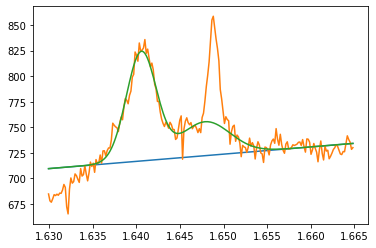

In [16]:

# Wow, that multi-component fit looks great.  Good deal.

#now we're going to use the continuum psf cube from a prior cell 
# with the Brackett model created in the above cell to create a full
# 3-D model of the central emission that isn't caused by the outflow [Fe II].

continuum_subcube = cont_psf_cube[wavemin:wavemax,:,:]
nz, ny, nx = continuum_subcube.shape

model_cube=np.zeros([nz,ny,nx])

#construct the scaled Brackett flux model
model_cube[0,:,:] = continuum_subcube[0,:,:] * (central_flux_model_only[0]/continuum_subcube[0, 30, 30])
for i in range(1, nz-2):
    model_cube[i,:,:] = continuum_subcube[i,:,:] * (central_flux_model_only[i] / continuum_subcube[i, 30, 30])
model_cube[nz-1,:,:] = continuum_subcube[nz-1,:,:] * (central_flux_model_only[nz-1] / continuum_subcube[nz-1,30,30])

# the full model of the AGN central emission is the continuum plus Brackett line.
full_model = continuum_subcube + model_cube

# subtract the model to create the final cube where the [Fe II] emission
# is isolated.
final_sub_cube = cube[wavemin:wavemax,:,:] - full_model

# make an appropriate header for the output sub-cube
header_cube_small = copy(header_cube)
del header_cube_small['CRVAL3']
header_cube_small['CRVAL3'] = wave[wavemin] * 10000.0
del header_cube_small['CRPIX3']
header_cube_small['CRPIX3'] = 1

# Save the .fits data sub-cube that has the continuum and Br model subtracted off of the
# [Fe II] emission, and the datacube that is the continuum+Br model.
fits.writeto('NGC4151_Hband_FinalSubtract.fits', final_sub_cube, header_cube_small, overwrite=True)
fits.writeto('NGC4151_Hband_ContinuumandBrackettModel.fits', full_model, header_cube_small, overwrite=True)
print('Continuum and Brackett subtracted cube saved.  Full model cube saved.')

#make a plot of the central spectrum, the full model and the continuum.
plt.figure(9)
plt.plot(minwave, continuum_subcube[:,30,30])
plt.plot(minwave, cube[wavemin:wavemax,30,30])
plt.plot(minwave, full_model[:,30,30])
plt.show()
